In [17]:
import random
import numpy as np
from data_process import get_FASHION_data, get_MUSHROOM_data
from scipy.spatial import distance
from models import Perceptron, SVM, Softmax, Logistic
from kaggle_submission import output_submission_csv
import matplotlib.pyplot as plt
%matplotlib inline

# For auto-reloading external modules
# See http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython|
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Loading Fashion-MNIST

In the following cells we determine the number of images for each split and load the images.
<br /> 
TRAIN_IMAGES + VAL_IMAGES = (0, 60000]
, TEST_IMAGES = 10000

In [2]:
# You can change these numbers for experimentation
# For submission we will use the default values 
TRAIN_IMAGES = 50000
VAL_IMAGES = 10000
normalize = True

In [3]:
data = get_FASHION_data(TRAIN_IMAGES, VAL_IMAGES, normalize=normalize)
X_train_fashion, y_train_fashion = data['X_train'], data['y_train']
X_val_fashion, y_val_fashion = data['X_val'], data['y_val']
X_test_fashion, y_test_fashion = data['X_test'], data['y_test']
n_class_fashion = len(np.unique(y_test_fashion))

In [4]:
n_class_fashion

10

# Loading Mushroom

In the following cells we determine the splitting of the mushroom dataset.
<br /> TRAINING + VALIDATION = 0.8, TESTING = 0.2

In [5]:
# TRAINING = 0.6 indicates 60% of the data is used as the training dataset.
VALIDATION = 0.2

In [6]:
data = get_MUSHROOM_data(VALIDATION)
X_train_MR, y_train_MR = data['X_train'], data['y_train']
X_val_MR, y_val_MR = data['X_val'], data['y_val']
X_test_MR, y_test_MR = data['X_test'], data['y_test']
n_class_MR = len(np.unique(y_test_MR))

print("Number of train samples: ", X_train_MR.shape[0])
print("Number of val samples: ", X_val_MR.shape[0])
print("Number of test samples: ", X_test_MR.shape[0])

Number of train samples:  4874
Number of val samples:  1625
Number of test samples:  1625


### Get Accuracy

In [7]:
n_class_MR
X_train_fashion.shape

(50000, 784)

This function computes how well your model performs using accuracy as a metric.

In [8]:
def get_acc(pred, y_test):
    return np.sum(y_test == pred) / len(y_test) * 100

In [9]:
def plot_accuracy_vs_lr(accuracy: np.ndarray, learning_rates: np.ndarray):
    # accuracy.shape = (n_epochs, learning_rate) where each column represent a learning rate
    # x-axis is epoch, and y-axis is accuracy
    epochs = np.arange(1, accuracy.shape[0] + 1)
    plt.figure(figsize=(10, 5))
    for i in range(accuracy.shape[1]):
        plt.plot(epochs, accuracy[:, i], label=f"learning rate = {learning_rates[i]}")

    fig = plt.gcf()
    fig.set_size_inches(10, 6)
    plt.title("Accuracy vs Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()
    

# Perceptron

Perceptron has 2 hyperparameters that you can experiment with:
- **Learning rate** - controls how much we change the current weights of the classifier during each update. We set it at a default value of 0.5, but you should experiment with different values. We recommend changing the learning rate by factors of 10 and observing how the performance of the classifier changes. You should also try adding a **decay** which slowly reduces the learning rate over each epoch.
- **Number of Epochs** - An epoch is a complete iterative pass over all of the data in the dataset. During an epoch we predict a label using the classifier and then update the weights of the classifier according to the perceptron update rule for each sample in the training set. You should try different values for the number of training epochs and report your results.

You will implement the Perceptron classifier in the **models/perceptron.py**

The following code: 
- Creates an instance of the Perceptron classifier class 
- The train function of the Perceptron class is trained on the training data
- We use the predict function to find the training accuracy as well as the testing accuracy


In [10]:
learning_rates = [1.5, 0.75, 0.25, 0.1, 0.05]

## Train Perceptron on Fashion-MNIST

### Training Perceptron with learning rate decay

In [11]:
n_epochs = 100
lr_accuracy = np.zeros((n_epochs, len(learning_rates)))

for i, lr in enumerate(learning_rates):
    percept_fashion = Perceptron(n_class_fashion, lr, n_epochs)
    accuracy = percept_fashion.train(X_train_fashion, y_train_fashion, X_test_fashion, y_test_fashion)
    lr_accuracy[:, i] = accuracy.squeeze()


Training Perceptron...
Epoch 1/100, Accuracy: 49.73%
Epoch 2/100, Accuracy: 66.99%
Epoch 3/100, Accuracy: 69.22%
Epoch 4/100, Accuracy: 71.15%
Epoch 5/100, Accuracy: 72.70%
Epoch 6/100, Accuracy: 74.42%
Epoch 7/100, Accuracy: 75.26%
Epoch 8/100, Accuracy: 76.40%
Epoch 9/100, Accuracy: 76.55%
Epoch 10/100, Accuracy: 77.39%
Epoch 11/100, Accuracy: 76.62%
Epoch 12/100, Accuracy: 76.98%
Epoch 13/100, Accuracy: 76.21%
Epoch 14/100, Accuracy: 76.44%
Epoch 15/100, Accuracy: 77.13%
Epoch 16/100, Accuracy: 77.14%
Epoch 17/100, Accuracy: 77.81%
Epoch 18/100, Accuracy: 78.18%
Epoch 19/100, Accuracy: 78.66%
Epoch 20/100, Accuracy: 79.32%
Epoch 21/100, Accuracy: 79.46%
Epoch 22/100, Accuracy: 80.24%
Epoch 23/100, Accuracy: 80.22%
Epoch 24/100, Accuracy: 80.80%
Epoch 25/100, Accuracy: 80.66%
Epoch 26/100, Accuracy: 81.16%
Epoch 27/100, Accuracy: 81.03%
Epoch 28/100, Accuracy: 81.36%
Epoch 29/100, Accuracy: 81.27%
Epoch 30/100, Accuracy: 81.45%
Epoch 31/100, Accuracy: 81.36%
Epoch 32/100, Accuracy: 8

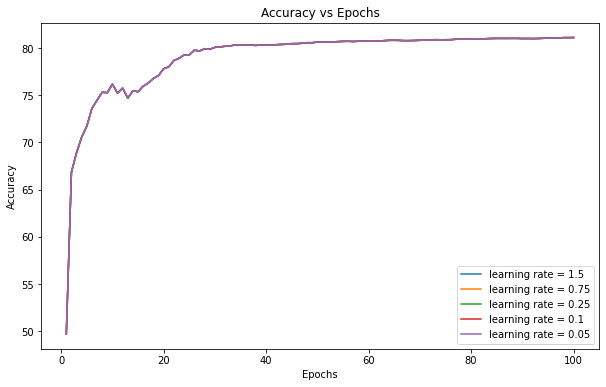

In [27]:
plot_accuracy_vs_lr(lr_accuracy, learning_rates)

In [37]:
lr = 0.01
n_epochs = 100

percept_fashion = Perceptron(n_class_fashion, lr, n_epochs)
accuracy = percept_fashion.train(X_train_fashion, y_train_fashion, X_test_fashion, y_test_fashion)

Training Perceptron...
Epoch 1/100, Accuracy: 49.73%
Epoch 2/100, Accuracy: 66.99%
Epoch 3/100, Accuracy: 69.22%
Epoch 4/100, Accuracy: 71.15%
Epoch 5/100, Accuracy: 72.70%
Epoch 6/100, Accuracy: 74.42%
Epoch 7/100, Accuracy: 75.26%
Epoch 8/100, Accuracy: 76.39%
Epoch 9/100, Accuracy: 76.55%
Epoch 10/100, Accuracy: 77.39%
Epoch 11/100, Accuracy: 76.63%
Epoch 12/100, Accuracy: 76.97%
Epoch 13/100, Accuracy: 76.22%
Epoch 14/100, Accuracy: 76.43%
Epoch 15/100, Accuracy: 77.13%
Epoch 16/100, Accuracy: 77.14%
Epoch 17/100, Accuracy: 77.81%
Epoch 18/100, Accuracy: 78.19%
Epoch 19/100, Accuracy: 78.66%
Epoch 20/100, Accuracy: 79.31%
Epoch 21/100, Accuracy: 79.46%
Epoch 22/100, Accuracy: 80.24%
Epoch 23/100, Accuracy: 80.21%
Epoch 24/100, Accuracy: 80.80%
Epoch 25/100, Accuracy: 80.66%
Epoch 26/100, Accuracy: 81.16%
Epoch 27/100, Accuracy: 81.03%
Epoch 28/100, Accuracy: 81.36%
Epoch 29/100, Accuracy: 81.26%
Epoch 30/100, Accuracy: 81.45%
Epoch 31/100, Accuracy: 81.36%
Epoch 32/100, Accuracy: 8

In [41]:
pred_percept = percept_fashion.predict(X_train_fashion)
print('The training accuracy is given by: %f' % (get_acc(pred_percept, y_train_fashion)))

The training accuracy is given by: 82.444000


### Validate Perceptron on Fashion-MNIST

In [42]:
pred_percept = percept_fashion.predict(X_val_fashion)
print('The validation accuracy is given by: %f' % (get_acc(pred_percept, y_val_fashion)))

The validation accuracy is given by: 81.440000


### Test Perceptron on Fashion-MNIST

In [43]:
pred_percept = percept_fashion.predict(X_test_fashion)
print('The testing accuracy is given by: %f' % (get_acc(pred_percept, y_test_fashion)))

The testing accuracy is given by: 81.120000


### Train Perceptron without Exponential Learning Rate Decay

In [29]:
lr = 0.75
n_epochs = 100

percept_fashion = Perceptron(n_class_fashion, lr, n_epochs, lr_decay=False)
accuracy = percept_fashion.train(X_train_fashion, y_train_fashion, X_test_fashion, y_test_fashion)

Training Perceptron...
Epoch 1/100, Accuracy: 49.73%
Epoch 2/100, Accuracy: 67.15%
Epoch 3/100, Accuracy: 69.44%
Epoch 4/100, Accuracy: 71.47%
Epoch 5/100, Accuracy: 73.30%
Epoch 6/100, Accuracy: 75.19%
Epoch 7/100, Accuracy: 75.60%
Epoch 8/100, Accuracy: 76.93%
Epoch 9/100, Accuracy: 74.16%
Epoch 10/100, Accuracy: 75.91%
Epoch 11/100, Accuracy: 73.84%
Epoch 12/100, Accuracy: 74.48%
Epoch 13/100, Accuracy: 74.84%
Epoch 14/100, Accuracy: 70.67%
Epoch 15/100, Accuracy: 68.05%
Epoch 16/100, Accuracy: 63.63%
Epoch 17/100, Accuracy: 68.27%
Epoch 18/100, Accuracy: 69.07%
Epoch 19/100, Accuracy: 74.30%
Epoch 20/100, Accuracy: 73.89%
Epoch 21/100, Accuracy: 75.72%
Epoch 22/100, Accuracy: 75.11%
Epoch 23/100, Accuracy: 76.10%
Epoch 24/100, Accuracy: 75.86%
Epoch 25/100, Accuracy: 76.31%
Epoch 26/100, Accuracy: 76.35%
Epoch 27/100, Accuracy: 76.23%
Epoch 28/100, Accuracy: 76.50%
Epoch 29/100, Accuracy: 75.65%
Epoch 30/100, Accuracy: 75.26%
Epoch 31/100, Accuracy: 73.20%
Epoch 32/100, Accuracy: 6

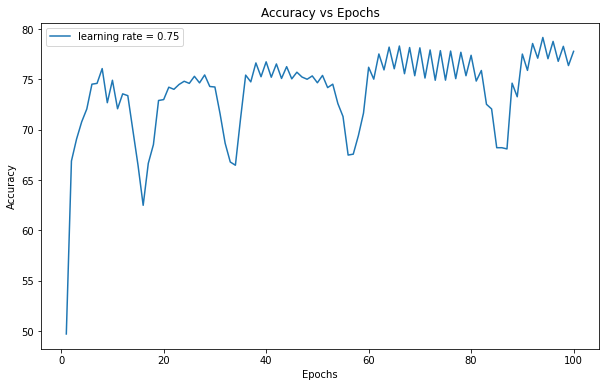

In [30]:
plot_accuracy_vs_lr(accuracy.reshape(100, 1), [lr])

### Perceptron_Fashion-MNIST Kaggle Submission

Once you are satisfied with your solution and test accuracy, output a file to submit your test set predictions to the Kaggle for Assignment 1 Fashion-MNIST. Use the following code to do so:

In [155]:
output_submission_csv('kaggle/perceptron_submission_fashion.csv', percept_fashion.predict(X_test_fashion))

## Train Perceptron on Mushroom

In [33]:
lr = 0.75
n_epochs = 100

percept_MR = Perceptron(n_class_MR, lr, n_epochs)
accuracy = percept_MR.train(X_train_MR, y_train_MR, X_test_MR, y_test_MR)

Training Perceptron...
Epoch 1/100, Accuracy: 51.68%
Epoch 2/100, Accuracy: 75.13%
Epoch 3/100, Accuracy: 48.32%
Epoch 4/100, Accuracy: 51.68%
Epoch 5/100, Accuracy: 65.10%
Epoch 6/100, Accuracy: 51.68%
Epoch 7/100, Accuracy: 48.28%
Epoch 8/100, Accuracy: 51.68%
Epoch 9/100, Accuracy: 64.20%
Epoch 10/100, Accuracy: 73.35%
Epoch 11/100, Accuracy: 74.89%
Epoch 12/100, Accuracy: 81.04%
Epoch 13/100, Accuracy: 72.73%
Epoch 14/100, Accuracy: 81.35%
Epoch 15/100, Accuracy: 73.23%
Epoch 16/100, Accuracy: 81.66%
Epoch 17/100, Accuracy: 75.44%
Epoch 18/100, Accuracy: 82.66%
Epoch 19/100, Accuracy: 74.39%
Epoch 20/100, Accuracy: 82.64%
Epoch 21/100, Accuracy: 77.41%
Epoch 22/100, Accuracy: 84.67%
Epoch 23/100, Accuracy: 76.16%
Epoch 24/100, Accuracy: 83.98%
Epoch 25/100, Accuracy: 76.88%
Epoch 26/100, Accuracy: 84.74%
Epoch 27/100, Accuracy: 77.23%
Epoch 28/100, Accuracy: 84.86%
Epoch 29/100, Accuracy: 77.29%
Epoch 30/100, Accuracy: 85.02%
Epoch 31/100, Accuracy: 77.62%
Epoch 32/100, Accuracy: 8

In [34]:
pred_percept = percept_MR.predict(X_train_MR)
print('The training accuracy is given by: %f' % (get_acc(pred_percept, y_train_MR)))

The training accuracy is given by: 87.853919


### Validate Perceptron on Mushroom

In [35]:
pred_percept = percept_MR.predict(X_val_MR)
print('The validation accuracy is given by: %f' % (get_acc(pred_percept, y_val_MR)))

The validation accuracy is given by: 87.569231


### Test Perceptron on Mushroom

In [36]:
pred_percept = percept_MR.predict(X_test_MR)
print('The testing accuracy is given by: %f' % (get_acc(pred_percept, y_test_MR)))

The testing accuracy is given by: 85.600000


# Support Vector Machines (with SGD)

Next, you will implement a "soft margin" SVM. In this formulation you will maximize the margin between positive and negative training examples and penalize margin violations using a hinge loss.

We will optimize the SVM loss using SGD. This means you must compute the loss function with respect to model weights. You will use this gradient to update the model weights.

SVM optimized with SGD has 3 hyperparameters that you can experiment with:
- **Learning rate** - similar to as defined above in Perceptron, this parameter scales by how much the weights are changed according to the calculated gradient update. 
- **Epochs** - similar to as defined above in Perceptron.
- **Regularization constant** - Hyperparameter to determine the strength of regularization. In this case it is a coefficient on the term which maximizes the margin. You could try different values. The default value is set to 0.05.

You will implement the SVM using SGD in the **models/svm.py**

The following code: 
- Creates an instance of the SVM classifier class 
- The train function of the SVM class is trained on the training data
- We use the predict function to find the training accuracy as well as the testing accuracy

## Train SVM on Fashion-MNIST

In [139]:
lr = 0.15
n_epochs = 50
reg_const = 0.01
batch_size = 1024

svm_fashion = SVM(n_class_fashion, lr, n_epochs, reg_const, batch_size)
svm_fashion.train(X_train_fashion, y_train_fashion)
svm_fashion.load_weights()

Training SVM...
Epoch 1/50, Accuracy: 75.31
Epoch 2/50, Accuracy: 79.51
Epoch 3/50, Accuracy: 82.62
Epoch 4/50, Accuracy: 77.40
Epoch 5/50, Accuracy: 79.30
Epoch 6/50, Accuracy: 82.53
Epoch 7/50, Accuracy: 82.36
Epoch 8/50, Accuracy: 82.23
Epoch 9/50, Accuracy: 83.14
Epoch 10/50, Accuracy: 81.86
Epoch 11/50, Accuracy: 77.39
Epoch 12/50, Accuracy: 81.13
Epoch 13/50, Accuracy: 79.76
Epoch 14/50, Accuracy: 81.57
Epoch 15/50, Accuracy: 83.07
Epoch 16/50, Accuracy: 83.16
Epoch 17/50, Accuracy: 83.00
Epoch 18/50, Accuracy: 84.20
Epoch 19/50, Accuracy: 83.46
Epoch 20/50, Accuracy: 79.71
Epoch 21/50, Accuracy: 78.17
Epoch 22/50, Accuracy: 84.06
Epoch 23/50, Accuracy: 80.84
Epoch 24/50, Accuracy: 84.82
Epoch 25/50, Accuracy: 81.19
Epoch 26/50, Accuracy: 82.95
Epoch 27/50, Accuracy: 79.40
Epoch 28/50, Accuracy: 78.94
Epoch 29/50, Accuracy: 81.33
Epoch 30/50, Accuracy: 79.37
Epoch 31/50, Accuracy: 82.37
Epoch 32/50, Accuracy: 81.50
Epoch 33/50, Accuracy: 80.01
Epoch 34/50, Accuracy: 79.22
Epoch 3

In [140]:
pred_svm = svm_fashion.predict(X_train_fashion)
print('The training accuracy is given by: %f' % (get_acc(pred_svm, y_train_fashion)))

The training accuracy is given by: 85.060000


### Validate SVM on Fashion-MNIST

In [141]:
pred_svm = svm_fashion.predict(X_val_fashion)
print('The validation accuracy is given by: %f' % (get_acc(pred_svm, y_val_fashion)))

The validation accuracy is given by: 84.190000


### Test SVM on Fashion-MNIST

In [142]:
pred_svm = svm_fashion.predict(X_test_fashion)
print('The testing accuracy is given by: %f' % (get_acc(pred_svm, y_test_fashion)))

The testing accuracy is given by: 83.160000


### SVM_Fashion-MNIST Kaggle Submission

Once you are satisfied with your solution and test accuracy output a file to submit your test set predictions to the Kaggle for Assignment 1 Fashion-MNIST. Use the following code to do so:

In [143]:
output_submission_csv('kaggle/svm_submission_fashion.csv', svm_fashion.predict(X_test_fashion))

## Train SVM on Mushroom

In [52]:
lr = 0.5
n_epochs = 10
reg_const = 0.001

svm_MR = SVM(n_class_MR, lr, n_epochs, reg_const)
svm_MR.train(X_train_MR, y_train_MR)

Training SVM...
Epoch 1/10, Accuracy: 94.50
Epoch 2/10, Accuracy: 94.01
Epoch 3/10, Accuracy: 94.40
Epoch 4/10, Accuracy: 89.27
Epoch 5/10, Accuracy: 93.56
Epoch 6/10, Accuracy: 94.62
Epoch 7/10, Accuracy: 95.26
Epoch 8/10, Accuracy: 89.19
Epoch 9/10, Accuracy: 91.05
Epoch 10/10, Accuracy: 93.46


In [53]:
pred_svm = svm_MR.predict(X_train_MR)
print('The training accuracy is given by: %f' % (get_acc(pred_svm, y_train_MR)))

The training accuracy is given by: 93.455068


### Validate SVM on Mushroom

In [54]:
pred_svm = svm_MR.predict(X_val_MR)
print('The validation accuracy is given by: %f' % (get_acc(pred_svm, y_val_MR)))

The validation accuracy is given by: 92.123077


## Test SVM on Mushroom

In [55]:
pred_svm = svm_MR.predict(X_test_MR)
print('The testing accuracy is given by: %f' % (get_acc(pred_svm, y_test_MR)))

The testing accuracy is given by: 92.430769


# Softmax Classifier (with SGD)

Next, you will train a Softmax classifier. This classifier consists of a linear function of the input data followed by a softmax function which outputs a vector of dimension C (number of classes) for each data point. Each entry of the softmax output vector corresponds to a confidence in one of the C classes, and like a probability distribution, the entries of the output vector sum to 1. We use a cross-entropy loss on this sotmax output to train the model. 

Check the following link as an additional resource on softmax classification: http://cs231n.github.io/linear-classify/#softmax

Once again we will train the classifier with SGD. This means you need to compute the gradients of the softmax cross-entropy loss function according to the weights and update the weights using this gradient. Check the following link to help with implementing the gradient updates: https://deepnotes.io/softmax-crossentropy

The softmax classifier has 3 hyperparameters that you can experiment with:
- **Learning rate** - As above, this controls how much the model weights are updated with respect to their gradient.
- **Number of Epochs** - As described for perceptron.
- **Regularization constant** - Hyperparameter to determine the strength of regularization. In this case, we minimize the L2 norm of the model weights as regularization, so the regularization constant is a coefficient on the L2 norm in the combined cross-entropy and regularization objective.

You will implement a softmax classifier using SGD in the **models/softmax.py**

The following code: 
- Creates an instance of the Softmax classifier class 
- The train function of the Softmax class is trained on the training data
- We use the predict function to find the training accuracy as well as the testing accuracy

## Train Softmax on Fashion-MNIST

In [ ]:
lr = 0.5
n_epochs = 10
reg_const = 0.5

softmax_fashion = Softmax(n_class_fashion, lr, n_epochs, reg_const)
softmax_fashion.train(X_train_fashion, y_train_fashion)

In [ ]:
pred_softmax = softmax_fashion.predict(X_train_fashion)
print('The training accuracy is given by: %f' % (get_acc(pred_softmax, y_train_fashion)))

### Validate Softmax on Fashion-MNIST

In [ ]:
pred_softmax = softmax_fashion.predict(X_val_fashion)
print('The validation accuracy is given by: %f' % (get_acc(pred_softmax, y_val_fashion)))

### Testing Softmax on Fashion-MNIST

In [ ]:
pred_softmax = softmax_fashion.predict(X_test_fashion)
print('The testing accuracy is given by: %f' % (get_acc(pred_softmax, y_test_fashion)))

### Softmax_Fashion-MNIST Kaggle Submission

Once you are satisfied with your solution and test accuracy output a file to submit your test set predictions to the Kaggle for Assignment 1 Fashion-MNIST. Use the following code to do so:

In [ ]:
output_submission_csv('kaggle/softmax_submission_fashion.csv', softmax_fashion.predict(X_test_fashion))

## Train Softmax on Mushroom

In [ ]:
lr = 0.5
n_epochs = 10
reg_const = 0.05

softmax_MR = Softmax(n_class_MR, lr, n_epochs, reg_const)
softmax_MR.train(X_train_MR, y_train_MR)

In [ ]:
pred_softmax = softmax_MR.predict(X_train_MR)
print('The training accuracy is given by: %f' % (get_acc(pred_softmax, y_train_MR)))

### Validate Softmax on Mushroom

In [ ]:
pred_softmax = softmax_MR.predict(X_val_MR)
print('The validation accuracy is given by: %f' % (get_acc(pred_softmax, y_val_MR)))

### Testing Softmax on Mushroom

In [ ]:
pred_softmax = softmax_MR.predict(X_test_MR)
print('The testing accuracy is given by: %f' % (get_acc(pred_softmax, y_test_MR)))

# Logistic Classifier

The Logistic Classifier has 2 hyperparameters that you can experiment with:
- **Learning rate** - similar to as defined above in Perceptron, this parameter scales by how much the weights are changed according to the calculated gradient update. 
- **Number of Epochs** - As described for perceptron.
- **Threshold** - The decision boundary of the classifier.


You will implement the Logistic Classifier in the **models/logistic.py**

The following code: 
- Creates an instance of the Logistic classifier class 
- The train function of the Logistic class is trained on the training data
- We use the predict function to find the training accuracy as well as the testing accuracy

### Training Logistic Classifer

In [32]:
y_train_MR

array([1, 0, 0, ..., 1, 1, 0], dtype=int64)

In [64]:
learning_rate = 0.7
n_epochs = 100
threshold = 0.5

lr = Logistic(learning_rate, n_epochs, threshold)
lr.train(X_train_MR, y_train_MR)

0.9969806630845547 0.0009926191695871773
Epoch 1/100, Accuracy: 87.34%
1.0 0.0
Epoch 2/100, Accuracy: 88.72%
1.0 0.0
Epoch 3/100, Accuracy: 89.52%
1.0 0.0
Epoch 4/100, Accuracy: 91.24%
1.0 0.0
Epoch 5/100, Accuracy: 92.57%
1.0 0.0
Epoch 6/100, Accuracy: 92.43%
1.0 0.0
Epoch 7/100, Accuracy: 92.57%
1.0 0.0
Epoch 8/100, Accuracy: 92.39%
1.0 0.0
Epoch 9/100, Accuracy: 92.78%
1.0 0.0
Epoch 10/100, Accuracy: 92.41%
1.0 0.0
Epoch 11/100, Accuracy: 92.94%
1.0 0.0
Epoch 12/100, Accuracy: 92.72%
1.0 0.0
Epoch 13/100, Accuracy: 93.58%
1.0 0.0
Epoch 14/100, Accuracy: 90.93%
1.0 0.0
Epoch 15/100, Accuracy: 91.79%
1.0 0.0
Epoch 16/100, Accuracy: 94.19%
1.0 0.0
Epoch 17/100, Accuracy: 93.19%
1.0 0.0
Epoch 18/100, Accuracy: 91.34%
1.0 0.0
Epoch 19/100, Accuracy: 91.57%
1.0 0.0
Epoch 20/100, Accuracy: 90.19%
1.0 0.0
Epoch 21/100, Accuracy: 95.45%
1.0 0.0
Epoch 22/100, Accuracy: 93.64%
1.0 0.0
Epoch 23/100, Accuracy: 95.42%
1.0 0.0
Epoch 24/100, Accuracy: 90.77%
1.0 0.0
Epoch 25/100, Accuracy: 86.56%
1

c:\Users\touba\OneDrive\桌面\CS444-MP\assignment1\models\logistic.py:30: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


Epoch 64/100, Accuracy: 91.20%
1.0 0.0
Epoch 65/100, Accuracy: 93.39%
1.0 0.0
Epoch 66/100, Accuracy: 94.77%
1.0 0.0
Epoch 67/100, Accuracy: 94.77%
1.0 0.0
Epoch 68/100, Accuracy: 94.05%
1.0 0.0
Epoch 69/100, Accuracy: 92.53%
1.0 0.0
Epoch 70/100, Accuracy: 92.59%
1.0 0.0
Epoch 71/100, Accuracy: 94.60%
1.0 0.0
Epoch 72/100, Accuracy: 90.95%
1.0 0.0
Epoch 73/100, Accuracy: 92.76%
1.0 0.0
Epoch 74/100, Accuracy: 94.65%
1.0 0.0
Epoch 75/100, Accuracy: 93.62%
1.0 0.0
Epoch 76/100, Accuracy: 91.22%
1.0 0.0
Epoch 77/100, Accuracy: 92.76%
1.0 0.0
Epoch 78/100, Accuracy: 91.83%
1.0 0.0
Epoch 79/100, Accuracy: 93.29%
1.0 0.0
Epoch 80/100, Accuracy: 94.11%
1.0 0.0
Epoch 81/100, Accuracy: 94.21%
1.0 0.0
Epoch 82/100, Accuracy: 94.52%
1.0 0.0
Epoch 83/100, Accuracy: 92.49%
1.0 0.0
Epoch 84/100, Accuracy: 89.45%
1.0 0.0
Epoch 85/100, Accuracy: 91.57%
1.0 0.0
Epoch 86/100, Accuracy: 95.06%
1.0 0.0
Epoch 87/100, Accuracy: 95.18%
1.0 0.0
Epoch 88/100, Accuracy: 94.01%
1.0 0.0
Epoch 89/100, Accuracy: 9

In [65]:
pred_lr = lr.predict(X_train_MR)
print('The training accuracy is given by: %f' % (get_acc(pred_lr, y_train_MR)))

The training accuracy is given by: 94.460402


c:\Users\touba\OneDrive\桌面\CS444-MP\assignment1\models\logistic.py:30: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


### Validate Logistic Classifer

In [66]:
pred_lr = lr.predict(X_val_MR)
print('The validation accuracy is given by: %f' % (get_acc(pred_lr, y_val_MR)))

The validation accuracy is given by: 94.215385


### Test Logistic Classifier

In [67]:
pred_lr = lr.predict(X_test_MR)
print('The testing accuracy is given by: %f' % (get_acc(pred_lr, y_test_MR)))

The testing accuracy is given by: 94.584615
